Load Data from Bigquery

In [ ]:

from google.cloud import bigquery

client = bigquery.Client()

project_id = "carbon-relic-439014-t0"
dataset_id = "chicago_taxi"
table_id = "data"

# Construct the fully qualified table name
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Load data into a Pandas DataFrame
query = f"SELECT * FROM `{table_ref}` ORDER BY timestamp DESC LIMIT 150000"
df = client.query(query).to_dataframe()

Data Analysis

In [ ]:
df.head()

In [ ]:
df.describe()
df.info()
df.duplicated().sum() # expected 0

In [ ]:
df.isna().sum()

In [ ]:
# Drop column with too many null values
df.drop(columns=["pickup_census_tract", "dropoff_census_tract", "dropoff_community_area", "dropoff_latitude", "dropoff_longitude", "dropoff_location"], inplace=True)

In [ ]:
df.shape
import seaborn as sns

# visual detection of outliers
sns.scatterplot(data=df, x="trip_miles",y="trip_seconds")

In [ ]:
df_test = df[df["trip_miles"] < 200]
df.shape
sns.scatterplot(data=df_test, x="trip_miles",y="trip_seconds")

In [ ]:
# outlier for target variable
sns.boxplot(x=df["trip_total"])

Feature Selection

In [ ]:
# Feature engineering
df["daytime"] = df["trip_start_timestamp"].dt.hour
df['day_type'] = df['trip_start_timestamp'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
df['month'] = df['trip_start_timestamp'].dt.month
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['day_of_month'] = df['trip_start_timestamp'].dt.day
df["avg_tips_per_taxi"] = df.groupby("taxi_id")["tips"].transform("mean")

In [ ]:
# Get first data frame for model creation to check feature importance
df_clean = df.drop(columns=["unique_key", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "timestamp", "fare", "tips", "trip_seconds", "pickup_location"])
df_clean.dropna(subset=["trip_total"], inplace=True)

In [ ]:
df_clean.head()

Setup tracking to mlflow

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from mlflow.models import infer_signature
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
TRACKING_URI = "https://mlflow-service-974726646619.us-central1.run.app"
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.autolog(disable=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(pipeline, numerical_cols, categorical_cols):
    """
    Plots aggregated feature importance from a trained pipeline.

    Args:
        pipeline (Pipeline): Trained scikit-learn pipeline containing a preprocessing step and an XGBoost model.
        numerical_cols (list): List of numerical feature names before transformation.
        categorical_cols (list): List of categorical feature names before transformation.
    """
    # Get feature importances from the model
    feature_importances = pipeline.named_steps["model"].feature_importances_

    # Retrieve transformed feature names from ColumnTransformer
    encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    ohe_feature_names = encoder.get_feature_names_out(categorical_cols)

    # Combine numerical and encoded categorical feature names
    all_feature_names = numerical_cols + list(ohe_feature_names)

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Importance": feature_importances
    })

    # Function to map one-hot encoded features back to their original categorical column
    def map_original_feature(feature_name):
        for cat_col in categorical_cols:
            if feature_name.startswith(cat_col + "_"):  # One-hot encoded feature
                return cat_col
        return feature_name  # Numerical features remain unchanged

    # Apply the mapping function
    feature_importance_df["Original Feature"] = feature_importance_df["Feature"].apply(map_original_feature)

    # Aggregate importance scores by original feature names
    aggregated_importance = feature_importance_df.groupby("Original Feature")["Importance"].sum().reset_index()

    # Sort by importance
    aggregated_importance = aggregated_importance.sort_values(by="Importance", ascending=False)

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(aggregated_importance["Original Feature"], aggregated_importance["Importance"])
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Feature Name")
    ax.set_title("Aggregated Feature Importance (Grouped)")
    ax.invert_yaxis()

    # Show plot
    plt.show()
    return fig

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature
def train_and_log_model(df, model_type, experiment_name="Chicago Taxi Regressor", description = ""):
    """
    Trains a regression model on given data and logs results to MLflow.

    Args:
        df (pd.DataFrame): Input DataFrame containing features and target.
        model_type (str): Model to use - "xgboost", "random_forest", "lightgbm", "catboost".
        experiment_name (str): Name of the MLflow experiment.

    Returns:
        pipeline (Pipeline): Trained model pipeline.
    """
    # Define categorical and numerical columns
    categorical_cols = ["payment_type", "company", "day_type"]
    numerical_cols = ["trip_miles", "tolls", "extras", "daytime", "month", "day_of_week", "day_of_month",
                      "avg_tips_per_taxi", "pickup_latitude", "pickup_longitude", "pickup_community_area"]
    target_column = "trip_total"

    # Split data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps with NaN handling
    preprocessor = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),  # Replace NaN with column mean for numerical features
            ("scaler", StandardScaler())  # Scale numerical features
        ]), numerical_cols),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),  # Replace NaN with most frequent value for categorical features
            ("onehot", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical variables
        ]), categorical_cols)
    ])
    # Select the model
    if model_type == "xgboost":
        model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42, objective="reg:squarederror")
    elif model_type == "random_forest":
        model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
    elif model_type == "lightgbm":
        model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)
    elif model_type == "catboost":
        model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=200)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Define the pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Set up MLflow experiment
    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

    tags = {
        "env": "experiment",
        "model_type": model_type,
        "experiment_description": "Taxi Regressor"
    }
    # Start MLflow run
    with mlflow.start_run(tags=tags, experiment_id=experiment.experiment_id, description=description) as run:
        # Train the pipeline
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Infer model signature
        input_example = X_test.iloc[0:100].dropna()
        signature = infer_signature(input_example, pipeline.predict(input_example))

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Print metrics
        print(f"MAE: {mae}")
        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"R2: {r2}")

        # Log metrics to MLflow
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        mlflow.log_param("Training Size", len(X_train))

        fig = plot_feature_importance(pipeline, numerical_cols, categorical_cols)
        mlflow.log_figure(fig, f'feature_importance_plot.png')
        
        # Log model hyperparameters
        model_params = pipeline.named_steps["model"].get_params()
        for param, value in model_params.items():
            mlflow.log_param(param, value)

        # Log the entire pipeline as a model
        mlflow.sklearn.log_model(pipeline, "model_pipeline", signature=signature, input_example=input_example)

        print("Model and metrics logged to MLflow.")

    return pipeline

In [ ]:
train_and_log_model(df_clean, "xgboost",description="Basic model with no outlier removal")

The created model performs badly and has questionable feature importance. Try a stricter outlier removal.

In [ ]:
# Stricter outlier removal
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    exclude_cols = {"pickup_latitude", "pickup_community_area", "pickup_latitude", "pickup_longitude", "tolls"}  # Set of columns to exclude
    numeric_cols = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_cols]
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        original_size = len(df)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        removed = original_size - len(df)
    return df


In [ ]:
df_new = df.copy()

In [ ]:
df_new["avg_tips_per_taxi"] = df_new.groupby("taxi_id")["tips"].transform("mean")
# Remove unneeded or mostly empty values
df_new = df_new[(df_new["trip_miles"] > 0) & (df_new["trip_total"] > 0)] 
df_new = df_new.drop(columns=["unique_key", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "timestamp", "fare", "tips", "trip_seconds", "pickup_location","pickup_census_tract", "dropoff_location", "dropoff_census_tract", "dropoff_community_area", "dropoff_latitude", "dropoff_longitude"])
df_new.dropna(subset=["trip_total"], inplace=True)

In [ ]:
df_new.shape

In [ ]:
df_new = remove_outliers(df_new)

In [ ]:
df_new.shape

In [ ]:
df_new.head()

C:\Users\User\PycharmProjects\Data Science Testing\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MAE: 2.666019272950861
MSE: 26.460185297050778
RMSE: 5.143946471052239
R2: 0.9192219659575819


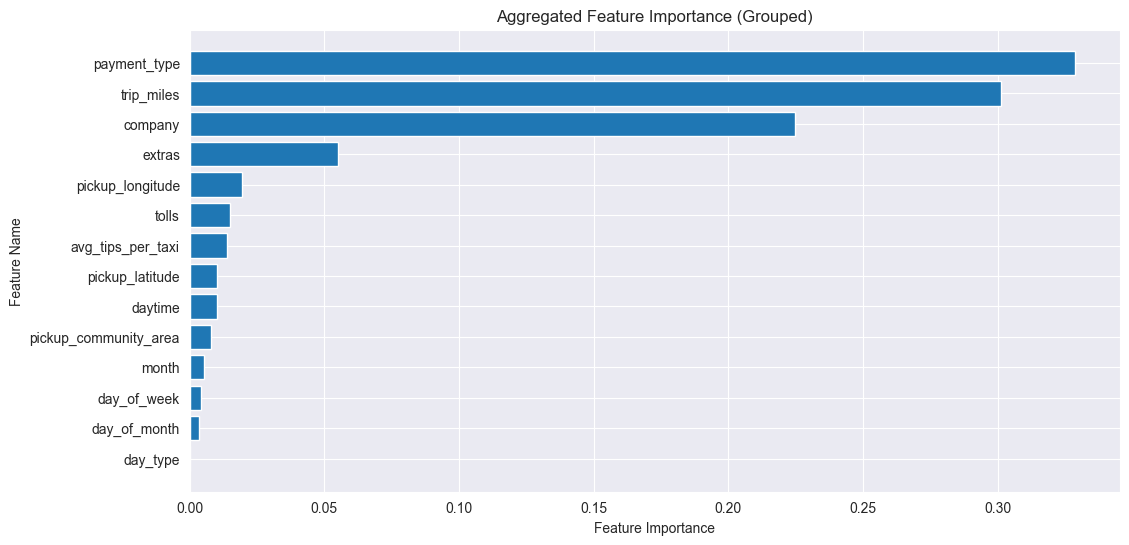

Model and metrics logged to MLflow.
🏃 View run marvelous-crab-75 at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/2/runs/8b09e9a95a714333a30e1528cb0af680
🧪 View experiment at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/2


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trip_miles', 'tolls',
                                                   'extras', 'daytime', 'month',
                                                   'day_of_week',
                                                   'day_of_month',
                                                   'avg_tips_per_taxi',
                                                   'pickup_latitude',
                                                   'pickup_longitude',
                                                   'pickup_community_area']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpu...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [167]:
train_and_log_model(df_new, model_type="xgboost", description="Basic model with outlier removal")

See different models for performance

In [ ]:
train_and_log_model(df_new, model_type="random_forest", description="Basic model with outlier removal")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 89741, number of used features: 51
[LightGBM] [Info] Start training from score 28.915201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\Users\User\PycharmProjects\Data Science Testing\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MAE: 2.6883169539082723
MSE: 26.673248904634487
RMSE: 5.164615078070629
R2: 0.9185715223135416


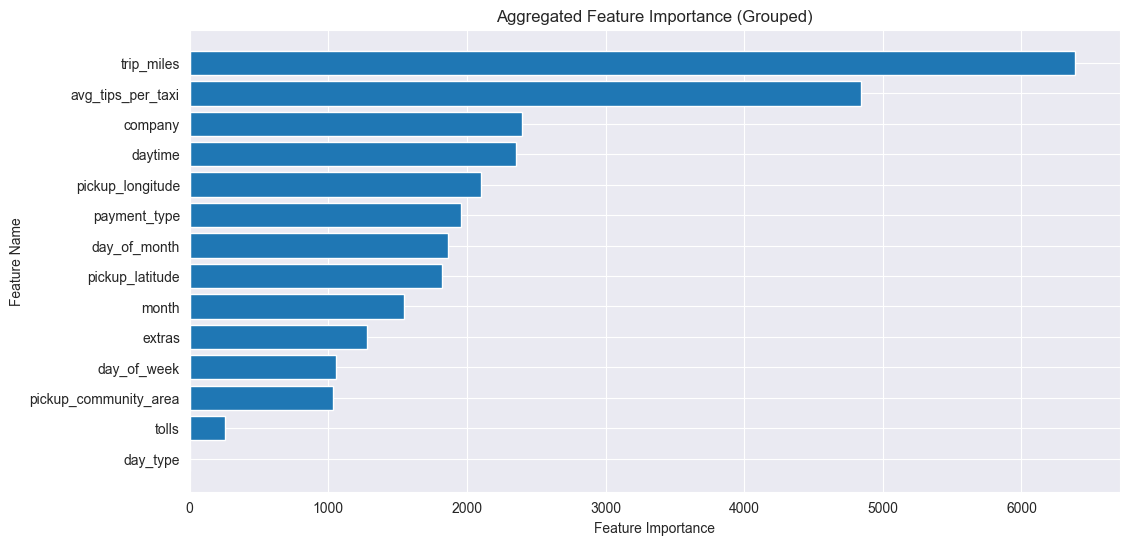

Model and metrics logged to MLflow.
🏃 View run glamorous-mouse-717 at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/2/runs/0b864e47573f45169953a38aeab90f3d
🧪 View experiment at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/2


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['trip_miles', 'tolls',
                                                   'extras', 'daytime', 'month',
                                                   'day_of_week',
                                                   'day_of_month',
                                                   'avg_tips_per_taxi',
                                                   'pickup_latitude',
                                                   'pickup_longitude',
                                                   'pickup_community_area']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['payment_type', 'company',
                                                   'day_type'])])),
                ('model',
                 LGBMRegressor(max_depth=6, n_estimators=1000,
                               random_state=42))])

In [168]:
train_and_log_model(df_new, model_type="lightgbm", description="Basic model with outlier removal")

In [ ]:
train_and_log_model(df_new, model_type="catboost", description="Basic model with outlier removal")

Use xgboost with best performance and try different hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# Experiment Name
experiment_name = "Chicago Taxi Regressor"

# Define categorical and numerical columns
categorical_cols = ["payment_type", "company", "day_type"]
numerical_cols = ["trip_miles", "tolls", "extras", "daytime", "month", "day_of_week", "day_of_month",
                  "avg_tips_per_taxi", "pickup_latitude", "pickup_longitude", "pickup_community_area"]
target_column = "trip_total"

# Split data into features and target
X = df_new.drop(columns=[target_column])
y = df_new[target_column]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps with NaN handling
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),  # Replace NaN with column mean
        ("scaler", StandardScaler())  # Scale numerical features
    ]), numerical_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Replace NaN with most frequent value
        ("onehot", OneHotEncoder(handle_unknown="ignore"))  # One-hot encode categorical variables
    ]), categorical_cols)
])

# Define Base Model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, 
                      random_state=42, objective="reg:squarederror")

# Define the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

# Define hyperparameter grid (corrected)
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 6, 10],  # Integer values only
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__subsample": [0.8, 1.0]  # Controls sample ratio for training
}

# Set up MLflow experiment
mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

tags = {
    "env": "experiment",
    "model_type": "xgboost",
    "experiment_description": "Taxi Regressor with Hyperparameter Tuning"
}
description = "XGBoost with hyperparameter tuning"

# Start parent MLflow run
with mlflow.start_run(experiment_id=experiment.experiment_id, tags=tags, description=description) as parent_run:
    # Perform GridSearch with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Iterate through all tested hyperparameter sets
    for i, (params, mean_score) in enumerate(
            zip(grid_search.cv_results_["params"], grid_search.cv_results_["mean_test_score"])):

        with mlflow.start_run(run_name=f"gridsearch_run_{i + 1}", nested=True) as child_run:
            # Train pipeline with specific hyperparameters
            pipeline.set_params(**params)
            pipeline.fit(X_train, y_train)

            # Make predictions
            y_pred = pipeline.predict(X_test)

            # Infer model signature
            input_example = X_test.iloc[0:100].dropna()
            signature = infer_signature(input_example, pipeline.predict(input_example))

            # Calculate evaluation metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            # Print metrics
            print(f"Run {i + 1} - Params: {params}")
            print(f"MAE: {mae}")
            print(f"MSE: {mse}")
            print(f"RMSE: {rmse}")
            print(f"R2: {r2}")

            # Log metrics to MLflow
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("MSE", mse)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("R2", r2)

            # Log hyperparameters
            for param, value in params.items():
                mlflow.log_param(param, value)

            # Log model
            mlflow.xgboost.log_model(pipeline.named_steps["model"], "model_pipeline")

    # Log the best model found by GridSearch
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)
    mlflow.xgboost.log_model(best_model.named_steps["model"], "best_model_pipeline")

    print("Best model and all hyperparameter runs logged to MLflow.")